In [2]:
torchaudio.set_audio_backend("soundfile")

In [134]:
import os
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np

def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

torchaudio.set_audio_backend("soundfile")
    
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, ch_id, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        
        print("Audio ID: ",ch_id)
        plt.figure()
        plt.plot(waveform.t().numpy())
        plt.show()
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths, ch_id


def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [131]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN but with layer norm instead of batch norm"""
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [132]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def test(model, device, test_loader, criterion, epoch, iter_meter, experiment):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with experiment.test():
        with torch.no_grad():
            for i, _data in enumerate(test_loader):
                if(i==30):
                    break
                spectrograms, labels, input_lengths, label_lengths, ch_id = _data 
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                
                
                output = model(spectrograms)  # (batch, time, n_class)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) # (time, batch, n_class)

                
                
                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(test_loader)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
                print("Actual Text  : ",decoded_targets)
                print("Decoded Text : ",decoded_preds)
                
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    experiment.log_metric('test_loss', test_loss, step=iter_meter.get())
    experiment.log_metric('cer', avg_cer, step=iter_meter.get())
    experiment.log_metric('wer', avg_wer, step=iter_meter.get())

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))


def main(learning_rate=5e-4, batch_size=20, epochs=10,
        train_url="train-clean-360", test_url="test-clean",
        experiment=Experiment(api_key='dummy_key', disabled=True)):

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    experiment.log_parameters(hparams)

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(9)
    device = torch.device("cuda" if use_cuda else "cpu")

    if not os.path.isdir("./data"):
        os.makedirs("./data")
        
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    kwargs = {}
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=1,
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)
     
    checkpoint = torch.load("finalcheck10.pth")
    model.load_state_dict(checkpoint["model__dict"])
#     checkpoint = torch.load("checkpoint9.pth")
#     model.load_state_dict(checkpoint)
    model.eval()
    
    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
        test(model, device, test_loader, criterion, epoch, iter_meter, experiment)
        break

In [127]:
if not os.path.isdir("./data"):
    os.makedirs("./data")
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

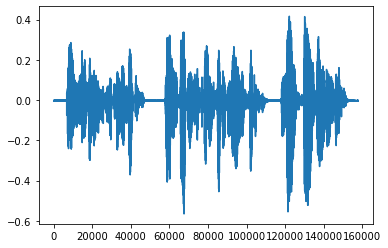

Actual Text  :  ['the news circulated with the rapidity of lightning during its progress it kindled every variety of coquetry desire and wild ambition']
Decoded Text :  ['the new circulated with the repedity of elihtening during its progress at kendled every bariative cocatry desire and wiled ambition']
Audio ID:  3980


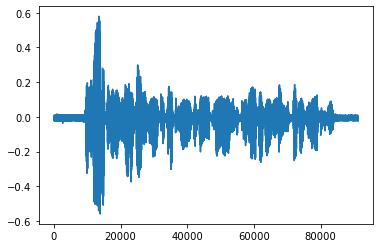

Actual Text  :  ['this attitude is universal and particularly developed in those who consider themselves better than others']
Decoded Text :  ['the satitude is universal and paroticualy developed in those who considered themselves better hanothers']
Audio ID:  3980


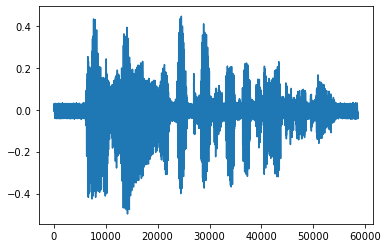

Actual Text  :  ['when i was a young man i thought paul was making too much of his call']
Decoded Text :  ['when i was young man i thought hall was mak ing too much of his call']
Audio ID:  134493


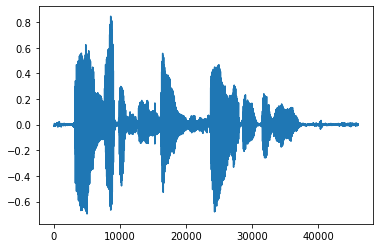

Actual Text  :  ["i never see lou's scythe over here"]
Decoded Text :  ['i never see lose side over her']
Audio ID:  68769


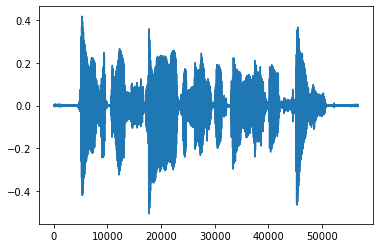

Actual Text  :  ['there was a grim smile of amusement on his shrewd face']
Decoded Text :  ['there was a grim smile of themesment on his shrut face']
Audio ID:  123288


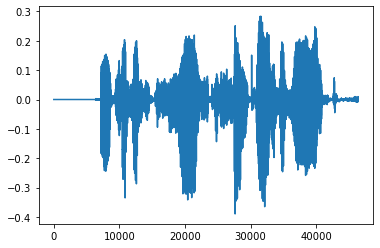

Actual Text  :  ['each of us is lashed to some part of the raft']
Decoded Text :  ['each of us is lashe to some part of the raft']
Audio ID:  134686


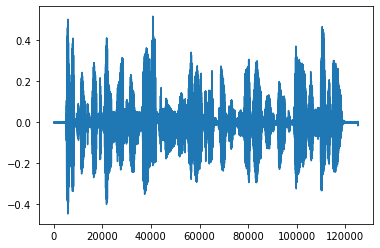

Actual Text  :  ['the retreat will begin on wednesday afternoon in honour of saint francis xavier whose feast day is saturday']
Decoded Text :  ["the retreat will begin on win's day after knoon n honor of saint frances zavior whose feast day is saterday"]
Audio ID:  122797


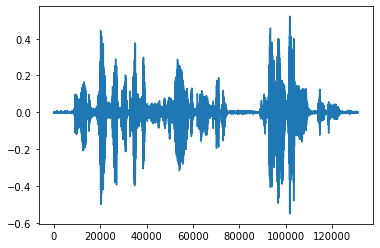

Actual Text  :  ['the wood flamed up splendidly under the large brewing copper and it sighed so deeply']
Decoded Text :  ['it wood flame dop splendedly under the large bruing copper and it side so seepily']
Audio ID:  279154


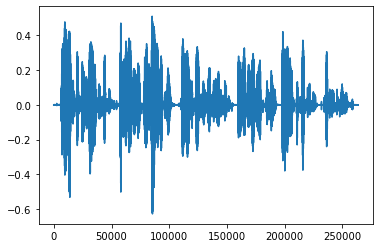

Actual Text  :  ['whether or not this principle is liable to exceptions everyone would agree that is has a broad measure of truth though the word exactly might seem an overstatement and it might seem more correct to say that ideas approximately represent impressions']
Decoded Text :  ['whether a not thisprinciple as liable to ecceptions every one would agree that it has a broad measure of truth though the word exactly migh seem an over statement and it my seen more correct to say that idas a proximantely represent impressions']
Audio ID:  134647


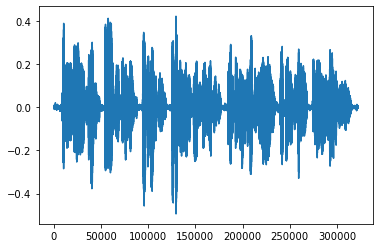

Actual Text  :  ['constantine easily believed that the heretics who presumed to dispute his opinions or to oppose his commands were guilty of the most absurd and criminal obstinacy and that a seasonable application of moderate severities might save those unhappy men from the danger of an everlasting condemnation']
Decoded Text :  ['constanteen esily believed that the harritics who prsums to dispete his opinions ar to oppose his commands wile guilty of the most obsured and criminal obstimacy and that a seasonable apliation of moderou sovarities might save those unhappy men from the danger of an ever lasting coundomnation']
Audio ID:  2273


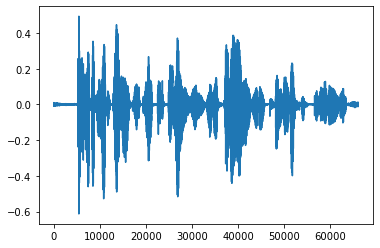

Actual Text  :  ["i haven't had a chance yet to tell you what a jolly little place i think this is"]
Decoded Text :  ['i havent had a chance yet to tell you woual a joly little place i think thisiys']
Audio ID:  294828


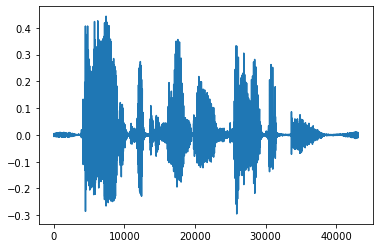

Actual Text  :  ['i asked for commander farragut']
Decoded Text :  ['i asked her commander farghath']
Audio ID:  1826


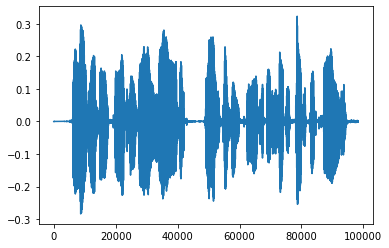

Actual Text  :  ['there might be a bit of poetry here and there but most of this place was such desperate prose']
Decoded Text :  ['ti migti obit of poortury here an therebut most of this place was such desperat pros']
Audio ID:  1826


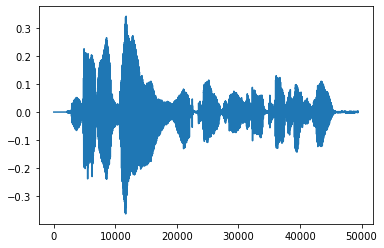

Actual Text  :  ['better go he had counselled sententiously']
Decoded Text :  ['better go yehad countles sand tentiously']
Audio ID:  85628


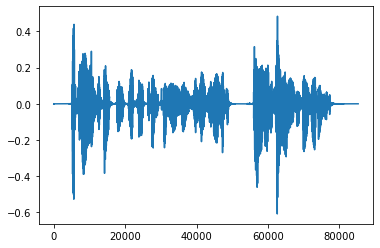

Actual Text  :  ['but you must not eat with your cap on your head she said and was going to take it off']
Decoded Text :  ['but you must not eat with your cap on your head she said and was going to they et off']
Audio ID:  122797


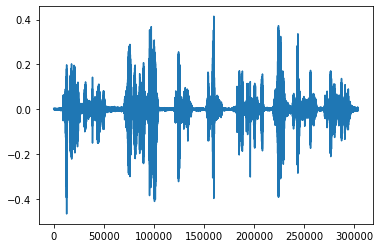

Actual Text  :  ['the axe struck deep into the very pith the tree fell to the earth with a sigh he felt a pang it was like a swoon he could not think of happiness for he was sorrowful at being separated from his home from the place where he had sprung up']
Decoded Text :  ['the axt struckdeep into the very pith the tree fell t the earth with a sih he felt a pang ntslike a swoon he could not think of happiness for he was sorrwful at being separated from his home from the place where he had sprung up']
Audio ID:  33396


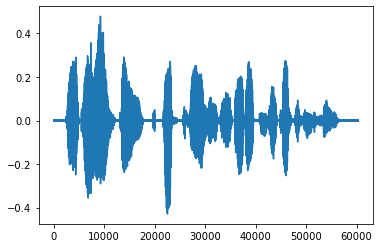

Actual Text  :  ['their eyes danced big thorleif stood up and stretched himself']
Decoded Text :  ['there eyes danced big torly stood up and stretched himself']
Audio ID:  122617


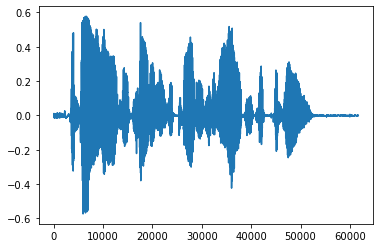

Actual Text  :  ['the delawares are children of the tortoise and they outstrip the deer']
Decoded Text :  ['the dellowars are children of the toartes an they out strip the dear']
Audio ID:  210777


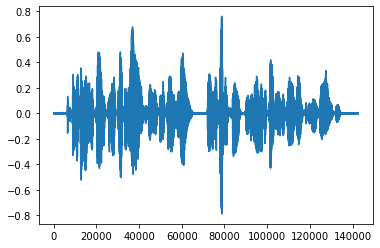

Actual Text  :  ['if you will give us your promise to meet captain battleax here at this time to morrow we will stretch a point and delay the departure of the john bright for twenty four hours']
Decoded Text :  ['if you will give us your promised to he cat om ataxs here at this time to morrow we will struetch a point and delay the departureof the johm bright for twein for hours']
Audio ID:  81414


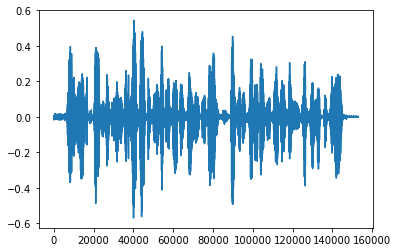

Actual Text  :  ['the story of its evil influence came back to me and in my bewildered condition i wondered whether there was not some truth in what had been said']
Decoded Text :  ['the story of its evil in fluincs came back to me and in my be wildered condition i wondered whether there was not some trothan wha had been said']
Audio ID:  210777


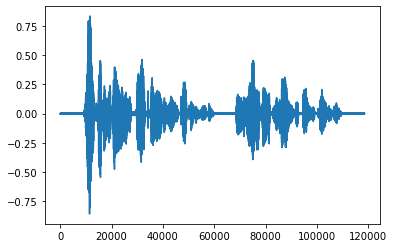

Actual Text  :  ['jack had been standing in the far corner of the room talking to eva and was now reduced to silence by his praises']
Decoded Text :  ['jack haveben standing in the for corner the room talkinto ever and was now reduced to silence by his praises']
Audio ID:  961


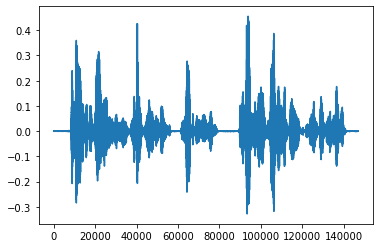

Actual Text  :  ['and now he desires to see the ideal state set in motion he would like to know how she behaved in some great struggle']
Decoded Text :  ['and thou he desirs to see ty ideal state sat in motion i would like to know how she ferhaved in some great struggle']
Audio ID:  2271


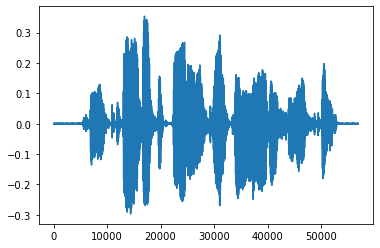

Actual Text  :  ['she must care about the theatre a great deal more than she used to']
Decoded Text :  ['she must car about the fater r gleat deal more than she used to']
Audio ID:  141084


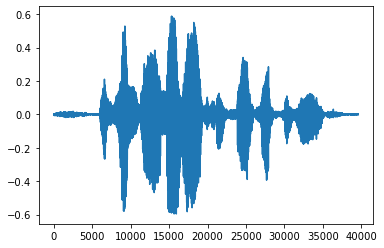

Actual Text  :  ['the indian i also thought nothing of']
Decoded Text :  ['the hindyan i also thought nothing of']
Audio ID:  70968


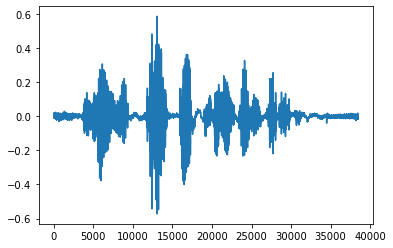

Actual Text  :  ['so i did push this fellow']
Decoded Text :  ['so i de push this fhellol']
Audio ID:  122797


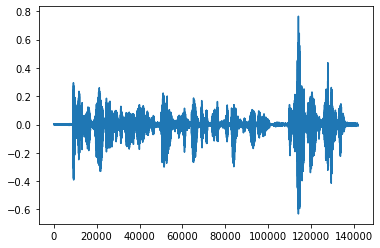

Actual Text  :  ['in the court yard some of the merry children were playing who had danced at christmas round the fir tree and were so glad at the sight of him']
Decoded Text :  ['in the cort yard some of the marria children were playing who had dance tac christmas round the fir tree and were so glad at the sigde of him']
Audio ID:  141083


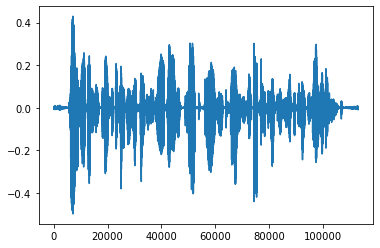

Actual Text  :  ['not only this but on the table i found a small ball of black dough or clay with specks of something which looks like sawdust in it']
Decoded Text :  ['not only this but on the table i found a small ball of black do er clay with spes of something which looks lie sodust in it']
Audio ID:  70968


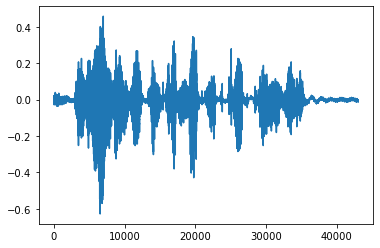

Actual Text  :  ['surely we can submit with good grace']
Decoded Text :  ['surely we can sumit with good grace']
Audio ID:  13754


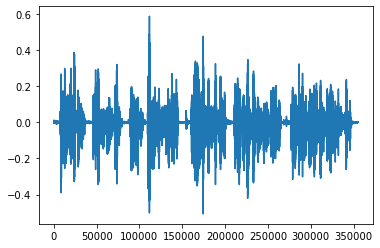

Actual Text  :  ["then the church was disincorporated and its property both real and personal confiscated and escheated to the government of the united states and although the personal property was soon restored real estate of great value long lay in the hands of the court's receiver and the mormon church had to pay the national government high rental on its own property"]
Decoded Text :  ['thad the church was disincoprated and its property wilth real and personal confiscated and essiated to the government of the united states and although tha personal property was soon restord relastat of great vallu long lay in the hands of the courts receiver and the morman church had to pay the national government high rental on its own property']
Audio ID:  134691


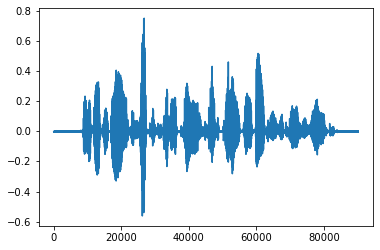

Actual Text  :  ['he stood still in deference to their calls and parried their banter with easy words']
Decoded Text :  ['he stood still indeference to their calls and parried ther banter with easy words']
Audio ID:  123440


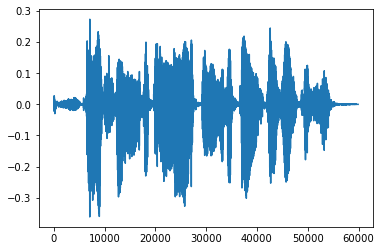

Test set: Average loss: 0.0044, Average CER: 0.105157 Average WER: 0.3047

SR:  16000


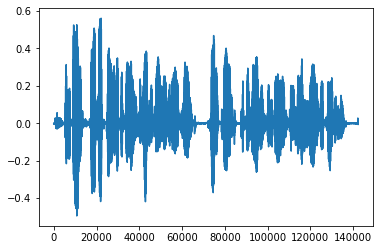

torch.Size([1, 142320])
tensor([[-0.0018, -0.0018, -0.0016,  ..., -0.0074, -0.0061, -0.0032]])
torch.Size([1, 1, 128, 712])
['the scout  elav id at the door to ascertainty were not observed thoughted prudent to preserve his disguiese unti the sshird of their privacy']


In [135]:
learning_rate = 5e-4
batch_size = 20
epochs = 10
libri_train_set = "train-clean-360"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set, experiment)

In [ ]:
import dill

In [7]:
comet_api_key = "SGsCDV7xaUuZGLSJifdnqt1L7" # add your api key here
project_name = "speechrecognition"
experiment_name = "speechrecognition-colab"

experiment = Experiment(api_key=comet_api_key, project_name=project_name, parse_args=False)
experiment.set_name(experiment_name)
experiment.display()

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/echo-abhinav/speechrecognition/f0262d48c4314391898f62a4461a903c



In [46]:
text_transform = TextTransform()

In [47]:
def decoder(output):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        for j, index in enumerate(args):
            if index != 28:
                if j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [145]:
def predict(file_path, learning_rate=5e-4, batch_size=1):
    
    file_path = file_path.name
    
    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": 10
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(9)
    device = torch.device("cuda" if use_cuda else "cpu")

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    #print(model)
    #print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)
     
    model.load_state_dict(torch.load("checkpoint7.pth"))
    model.eval()
    
    spectrograms = []
    waveform, sampling_rate = torchaudio.load(file_path)
    #print(waveform.size())
    #print(sampling_rate)
    spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
    spectrograms.append(spec)
        
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    spectrograms = spectrograms.to(device)
    
    print(spectrograms.size())
    output = model(spectrograms)  # (batch, time, n_class)
    output = F.log_softmax(output, dim=2)
    output = output.transpose(0, 1) # (time, batch, n_class)
    
    decoded_preds, decoded_targets = decoder(output.transpose(0, 1))
    print(decoded_preds)
    
    return decoded_preds
    
    

In [147]:
def predict(file_path, learning_rate=5e-4, batch_size=1):
    
    file_path = file_path.name
    
    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": 10
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(9)
    device = torch.device("cuda" if use_cuda else "cpu")

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    #print(model)
    #print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)
     
    checkpoint = torch.load("finalcheck10.pth")
    model.load_state_dict(checkpoint["model__dict"])
    model.eval()
    
#     checkpoint = torch.load("fullcheck8.pth")
#     model.load_state_dict(checkpoint["model__dict"])
#     model.eval()
    
    spectrograms = []
    waveform, sample_rate = torchaudio.load(file_path)
    print("sampling rate: ",sample_rate)
    plt.figure()
    plt.plot(waveform.t().numpy())
    plt.show()
    
    with torch.no_grad():
        spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)

        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        spectrograms = spectrograms.to(device)

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)

        decoded_preds, decoded_targets = decoder(output)
        print("Decoded text: ",decoded_preds)
        
    return decoded_preds

SR:  16000


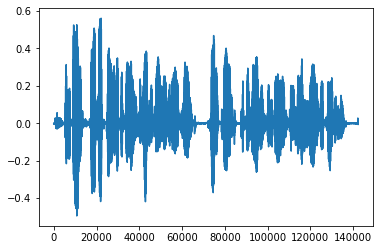

torch.Size([1, 142320])
tensor([[-0.0018, -0.0018, -0.0016,  ..., -0.0074, -0.0061, -0.0032]])
torch.Size([1, 1, 128, 712])
['the scout  elav id at the door to ascertainty were not observed thoughted prudent to preserve his disguiese unti the sshird of their privacy']


In [82]:
predict('scout.flac')

Running on local URL:  http://127.0.0.1:7869/

To create a public link, set `share=True` in `launch()`.


sampling rate:  16000


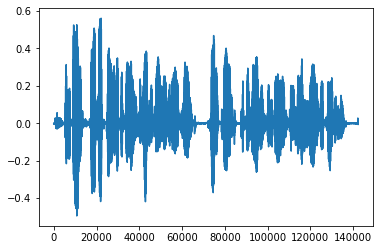

Decoded text:  ['the scout who had left daveid at the door to ascertan they were not observed thoughted prudent to preserve his disguise und tilish a a a ovacy']
sampling rate:  16000


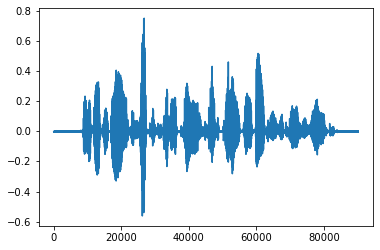

Decoded text:  ['he stood still indeference to their calls and parried their banter with eaae']
sampling rate:  16000


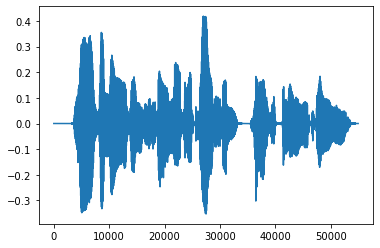

Decoded text:  ['no believe in someducation a  aer']
sampling rate:  16000


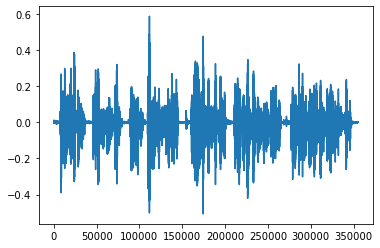

Decoded text:  ['thad the church was disincoprated and its property wilth real and personal confiscated and essiated to the government of the udited states and although the personal property was soon restord relastad of great vallu long lay in the hands of the courts receiver and the worman church had to pay the national goa a entll on its on property']
sampling rate:  16000


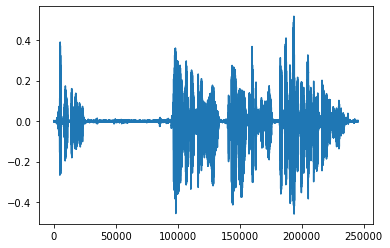

Decoded text:  ['chaptor a levin the maro brouht a very sober looking morning the son making only a few efforts to appear and cathran agard from it every thing a ae to her wishes']
sampling rate:  16000


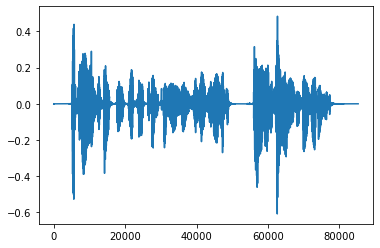

Decoded text:  ['but you must not eat with your cap on your head she said and was boin aa']
sampling rate:  16000


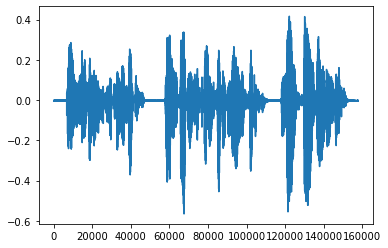

Decoded text:  ['the new circulated with the repedity of elihtnin during its progress at kendled every bariative cocatry desire anda a a mbition']
sampling rate:  16000


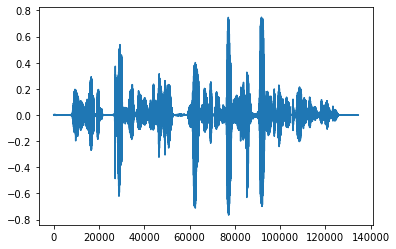

Decoded text:  ['yes something aavery thing said rachal hurdly looking frondingly at a flower which she was tworl e aas']
sampling rate:  16000


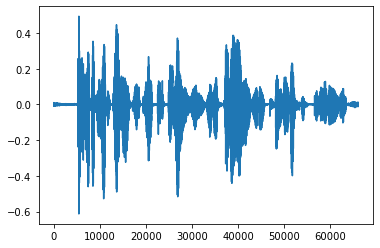

Decoded text:  ['i havent had a chance get to tell you what a jolly little pl a a as']


In [ ]:
import gradio as gr

iface = gr.Interface(fn=predict, inputs="file", outputs="text")
iface.launch(debug=True)